In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import json

In [73]:
file_path = '/home/ekagra/Desktop/Study/IMECE/visualization/adversarial-distance-estimation/data/paper_data/standard_model_eval_500.json'
# file_path = '/home/ekagra/Desktop/Study/IMECE/visualization/adversarial-distance-estimation/clever_data_robust_L2.json'

with open(file_path, 'r') as f:
    data = json.load(f)

In [75]:
norm = 2

min_adv_dist = []
color_adv = []
labels = []

In [76]:
clever_score = data[f'{norm}']['clever_score']
adv_dist_pgd = data[f'{norm}']['adversarial_distance_pgd']
adv_dist_sec_att = data[f'{norm}']['adversarial_distance_second_attack']
indices = data[f'{norm}']['indices']

In [77]:
for i, dist in enumerate(adv_dist_pgd):
    if dist<adv_dist_sec_att[i]:
        min_adv_dist.append(dist)
        color_adv.append('blue')
        labels.append('Adversarial Distance (PGD)')
    else:
        min_adv_dist.append(adv_dist_sec_att[i])
        color_adv.append('green')
        labels.append('Adversarial Distance (Second attack)')

colors = ['red' if adv < clv else 'black' for adv, clv in zip(min_adv_dist, clever_score)]

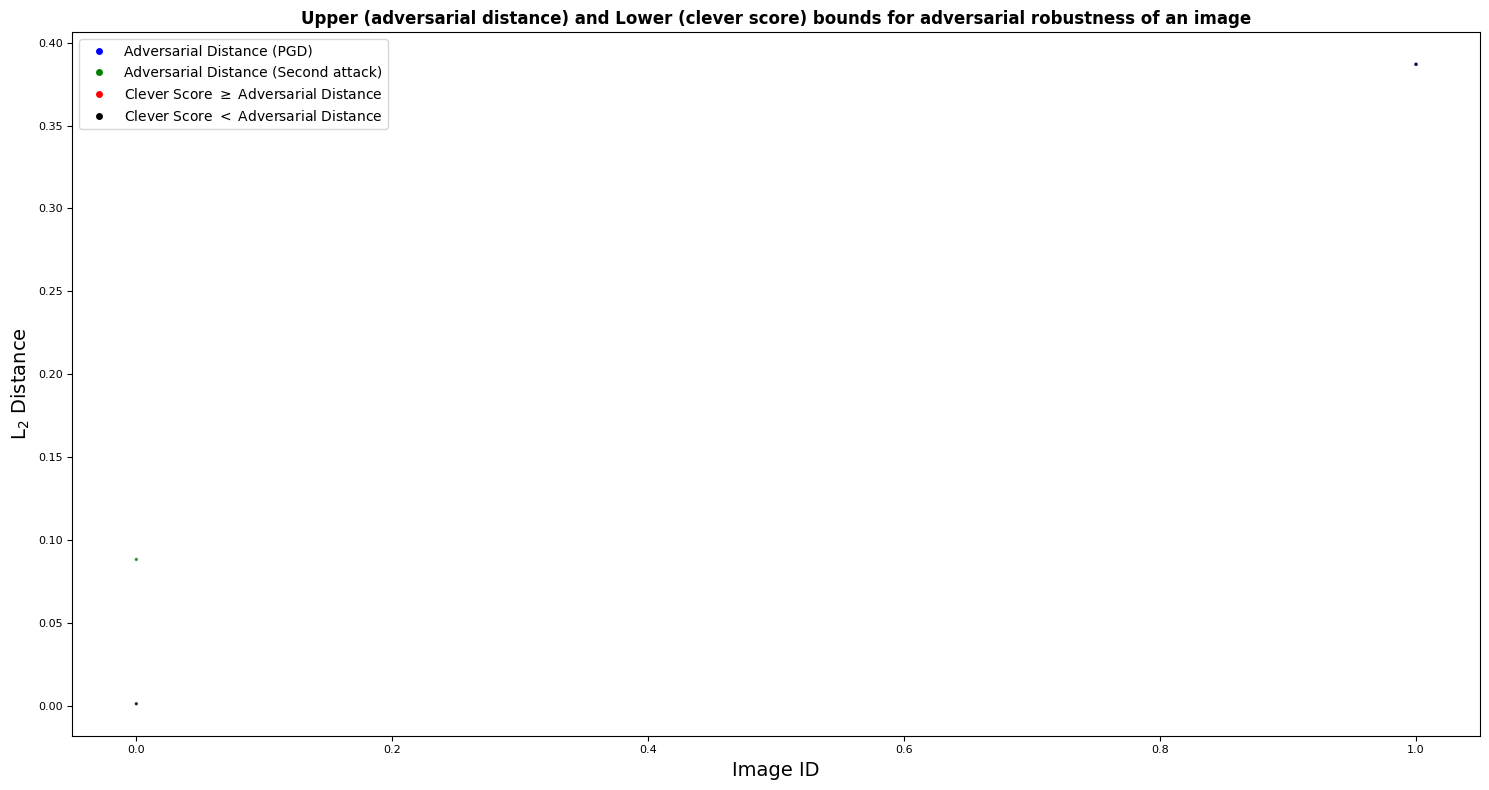

In [78]:
plt.figure(figsize=(15, 8))
plt.scatter(indices, min_adv_dist, alpha=0.7, label=labels, s=2, c=color_adv)
plt.scatter(indices, clever_score, alpha=0.7, label=labels, s=2, c=colors)

legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Adversarial Distance (PGD)'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Adversarial Distance (Second attack)'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Clever Score $\geq$ Adversarial Distance'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Clever Score $<$ Adversarial Distance')
]

plt.xlabel('Image ID', fontsize=14)
plt.ylabel(f'L$_{norm}$ Distance', fontsize=14)
plt.title('Upper (adversarial distance) and Lower (clever score) bounds for adversarial robustness of an image', weight='bold')
plt.tick_params('both', labelsize=8)
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()